In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import random
from sklearn.preprocessing import StandardScaler

In [4]:
from project_helper import *

## Separate Data Subsets

In [5]:
# read source data
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [6]:
# seed for consistent splits
random.seed(1636)

# all idxs
idxs = list(range(len(df)))

# shuffle and split
random.shuffle(idxs)
split = int(len(idxs)*0.7)
train_all = idxs[:split]
test_all = idxs[split:]

# idxs of outliers
outlier_idxs = list((df.MSA_abbr == 'NEW_ORLEANS_LA').nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'MEMPHIS_TN') & (df.year == 2016)).nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'BATON_ROUGE_LA') & (df.year == 2007)).nonzero()[0])

# cleaned idxs
train_idxs = [idx for idx in train_all if idx not in outlier_idxs]
test_idxs = [idx for idx in test_all if idx not in outlier_idxs]

In [7]:
# get labels because these don't need to change

label = 'murder_per_100_k'
y = df[label]

y_train = y.iloc[train_idxs]
y_test = y.iloc[test_idxs]

print('Train Len:\t {} \nTest Len:\t {}'.format(len(y_train),len(y_test)))

Train Len:	 640 
Test Len:	 276


#### MSA + Year

In [8]:
# select only relevant features
msa_yr_cols = ['MSA_abbr','year']
x_msa_yr_df = df[msa_yr_cols]

# one-hot encoding of MSAs
x_msa_yr_dummies = pd.get_dummies(x_msa_yr_df['MSA_abbr'])

# rescale year for approx [0.1 , 1.0] to resemble MSA encoding scale
x_msa_yr_year = (x_msa_yr_df['year']-2005)/11

# combine new features
x_msa_yr = pd.concat([x_msa_yr_dummies, x_msa_yr_year], axis=1)

# train test split
x_train_msayr = x_msa_yr.iloc[train_idxs]
x_test_msayr = x_msa_yr.iloc[test_idxs]

print('Train X and y match: {}'.format(len(x_train_msayr)==len(y_train)))
print('Test  X and y match: {}'.format(len(x_test_msayr)==len(y_test)))
print('\nNumber of Predictors: {}'.format(len(x_train_msayr.columns)))

Train X and y match: True
Test  X and y match: True

Number of Predictors: 107


#### MSA + Year + Features

In [9]:
# drop irrelevant columns
x_features_df = df.drop(['MSA_orig', 'MSA_corr', 'MSA_abbr', 'year','murder_per_100_k'], axis=1)

# standardize, fitting only on training rows
standardizer = StandardScaler().fit(x_features_df.iloc[train_idxs])
x_features = pd.DataFrame(standardizer.transform(x_features_df), columns=x_features_df.columns)

# combine with previous MSA encodings and year
x_feats_msa_yr = pd.concat([x_features, x_msa_yr], axis=1)

# train test split
x_train_featmsayr = x_feats_msa_yr.iloc[train_idxs]
x_test_featmsayr = x_feats_msa_yr.iloc[test_idxs]

print('Train X and y match: {}'.format(len(x_train_featmsayr)==len(y_train)))
print('Test  X and y match: {}'.format(len(x_test_featmsayr)==len(y_test)))
print('\nNumber of Predictors: {}'.format(len(x_train_featmsayr.columns)))

Train X and y match: True
Test  X and y match: True

Number of Predictors: 115


#### Features + Year

In [10]:
# combine relevant columns from previous subsets
x_feats_yr = pd.concat([x_features, x_msa_yr_year], axis=1)

# train test split
x_train_featyr = x_feats_yr.iloc[train_idxs]
x_test_featyr = x_feats_yr.iloc[test_idxs]

print('Train X and y match: {}'.format(len(x_train_featyr)==len(y_train)))
print('Test  X and y match: {}'.format(len(x_test_featyr)==len(y_test)))
print('\nNumber of Predictors: {}'.format(len(x_train_featyr.columns)))

print('\nFEATURE NAMES:')
for name in x_train_featyr.columns:
    print(' -'+name)

Train X and y match: True
Test  X and y match: True

Number of Predictors: 9

FEATURE NAMES:
 -now_married_except_separated
 -less_than_high_school_diploma
 -unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months
 -households_with_food_stamp_snap_benefits
 -percentage_married-couple_family
 -percentage_female_householder_no_husband_present_family
 -poverty_all_people
 -house_median_value_(dollars)
 -year


## Fitting The Models

In [11]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [12]:
# instantiate and fit models
def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=5).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.2,1.4,1.6,1.8]}).fit(x_train, y_train).best_estimator_
    md['knn'] = GridSearchCV(KNeighborsRegressor(),{'n_neighbors':[5,10,20,40]}).fit(x_train, y_train).best_estimator_
    md['adaboosst'] = GridSearchCV(AdaBoostRegressor(), {'learning_rate':[0.1,0.3,0.6,1.0]}).fit(x_train, y_train).best_estimator_
    md['svr'] = GridSearchCV(SVR(), {'C':[0.01,0.1,1,10,100],'epsilon':[0.001,0.01,0.1,1,10]}).fit(x_train, y_train)
    
    return md

In [13]:
# MSA + Year
exp_1 = run_experiment(make_models, 10, x_train_msayr, y_train, x_test_msayr, y_test)
print('1: Done')

# MSA + Year + Features
exp_2 = run_experiment(make_models, 10, x_train_featmsayr, y_train, x_test_featmsayr, y_test)
print('2: Done')

# Features + Year
exp_3 = run_experiment(make_models, 10, x_train_featyr, y_train, x_test_featyr, y_test)
print('3: Done')

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


1: Done
2: Done
3: Done


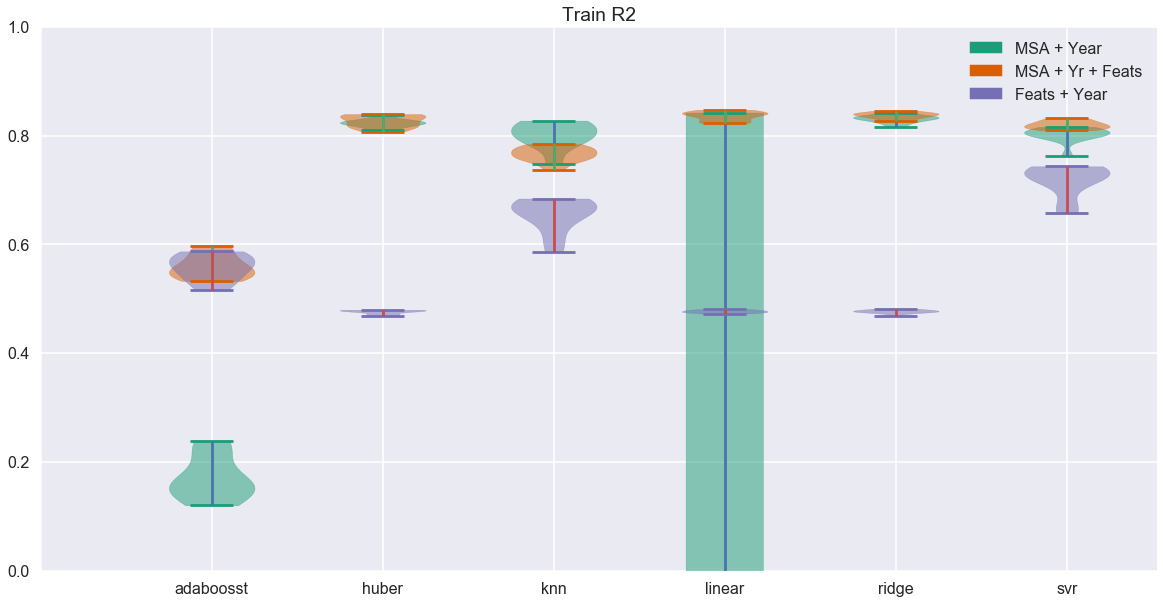

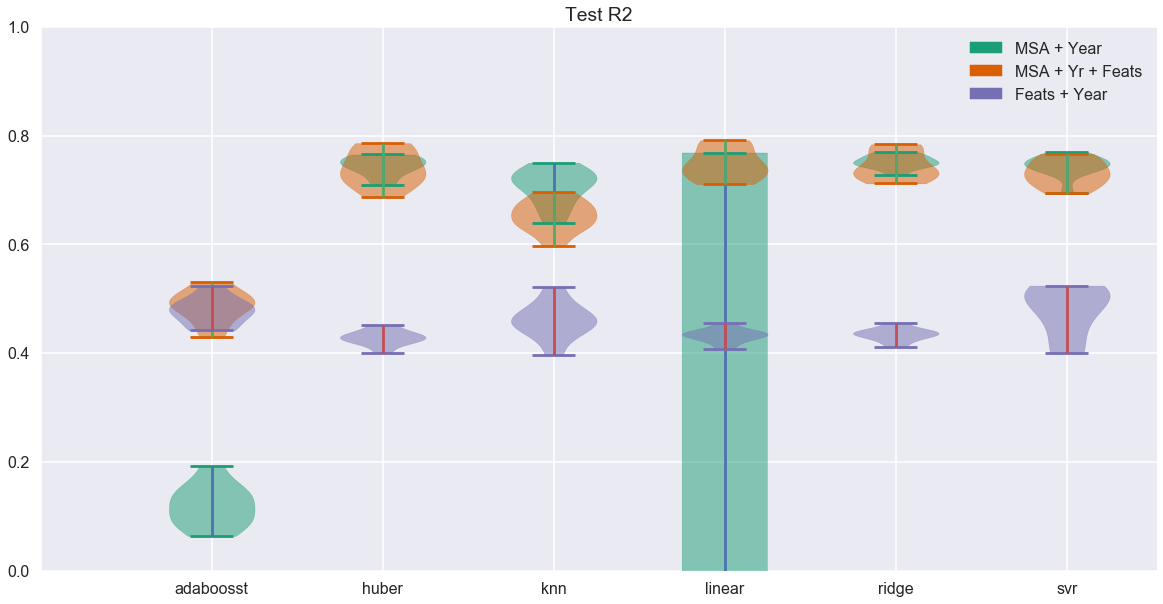

In [14]:
violin_plots([exp_1, exp_2, exp_3],
             ['Train R2','Test R2'],
             experiment_name=['MSA + Year','MSA + Yr + Feats','Feats + Year'],
             center_zero=False)